Курсовая работа

05. Классификация: превышает ли значение IC50 медианное значение выборки

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 21.1 MB/s eta 0:00:00


In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import joblib
import optuna
import pickle
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [ ]:
# Загрузка  данных
df_standardscaler = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Classic_ML_Vo_PJ/df_standardscaler.csv')

In [ ]:
# Выведим размерность датафрейма
df_standardscaler.shape

(969, 188)

In [ ]:
# Выведим первые строки датафрейма
df_standardscaler.head()

,IC50,CC50,SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,-0.599333,-0.648886,0.023693,-1.766931,-1.766931,1.230105,0.859969,-0.751719,1.076111,0.260487,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,2.268081,-0.085302
1,-0.623447,-0.917447,-0.258103,-2.112017,-2.112017,2.098636,0.953566,-0.540135,1.257528,0.292155,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,2.268081,-0.085302
2,0.360199,-0.671529,-0.341875,-2.518530,-2.518530,2.154087,0.959542,-1.485466,1.017293,0.748665,...,6.379466,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,2.268081,-0.085302
3,-0.619328,-0.755671,0.492044,-1.765937,-1.765937,1.250111,0.862125,-0.937063,0.991464,0.370656,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,3.080565,-0.085302
4,-0.154375,-0.706065,-0.334138,-1.749744,-1.749744,0.538633,0.785453,-0.696952,0.567012,0.905000,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,-0.169372,-0.085302


In [ ]:
# Выбираем целевую переменную — это IC50
y = df_standardscaler['IC50']  # Целевая переменная

# Рассчитываем медианное значение IC50
median_ic50 = y.median()

# Преобразуем задачу регрессии в задачу бинарной классификации:
# - 1: если IC50 > median (высокое значение)
# - 0: если IC50 <= median (низкое значение)
y_binary = (y > median_ic50).astype(int)  # Бинарная целевая переменная


# Формируем матрицу признаков, исключая SI, CC50 и саму IC50
X = df_standardscaler.drop(columns=['SI', 'CC50', 'IC50'])  # Признаки


# Разделяем данные на обучающую и тестовую выборки в соотношении 70:30
# random_state=42 — обеспечивает воспроизводимость результата
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary,
    test_size=0.3,
    random_state=42
)


# Словарь с классами классификаторов, которые будут оптимизироваться
CLASSIFIERS = {
    'XGBClassifier': XGBClassifier,
    'DecisionTreeClassifier': DecisionTreeClassifier,
    'RandomForestClassifier': RandomForestClassifier,
    'CatBoostClassifier': CatBoostClassifier
}


# Функция-объектив для Optuna, которая будет оценивать модель
def objective(trial, classifier_name):
    """ Функция для поиска гиперпараметров модели с помощью Optuna """

    if classifier_name == 'XGBClassifier':
        params = {
            'objective': 'binary:logistic',
            'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'n_estimators': trial.suggest_int('n_estimators', 50, 550),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        }
        model = XGBClassifier(**params)

    elif classifier_name == 'DecisionTreeClassifier':
        params = {
            'max_depth': trial.suggest_int('max_depth', 1, 15),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        }
        model = DecisionTreeClassifier(**params)

    elif classifier_name == 'RandomForestClassifier':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 550),
            'max_depth': trial.suggest_int('max_depth', 1, 15),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        }
        model = RandomForestClassifier(**params)

    elif classifier_name == 'CatBoostClassifier':
        params = {
            'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
            'depth': trial.suggest_int('depth', 1, 10),
            'iterations': trial.suggest_int('iterations', 50, 550),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-4, 10, log=True),
            'verbose': 0  # Отключаем выводы обучения
        }
        model = CatBoostClassifier(**params)

    # Обучаем модель
    model.fit(X_train, y_train)

    # Делаем предсказания
    y_pred = model.predict(X_test)

    # Оцениваем качество по метрике accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy  # Возвращаем accuracy как цель оптимизации


# Хранение результатов оптимизации моделей
best_models = {}

# Проходимся по всем классификаторам из словаря CLASSIFIERS
for classifier_name in CLASSIFIERS.keys():
    print(f"Оптимизация гиперпараметров для {classifier_name}...")
    study = optuna.create_study(direction='maximize')  # Создаём исследование Optuna для максимизации accuracy
    study.optimize(lambda trial: objective(trial, classifier_name), n_trials=200)  # Ищем лучшие параметры

    best_params = study.best_params  # Получаем лучшие параметры
    best_model = CLASSIFIERS[classifier_name](**best_params).fit(X_train, y_train)  # Обучаем модель с этими параметрами
    best_models[classifier_name] = {
        'best_params': best_params,   # Лучшие гиперпараметры
        'best_model': best_model      # Лучшая обученная модель
    }

    print(f"Лучшие гиперпараметры для {classifier_name}:")
    print(best_params)


# Оценка качества моделей на тестовых данных
print("\n=== Результаты на тестовых данных ===\n")
for classifier_name, model_data in best_models.items():
    best_model = model_data['best_model']
    y_test_pred = best_model.predict(X_test)

    # Подсчёт метрик
    accuracy = accuracy_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    # Вывод результатов
    print(f"{classifier_name}")
    print(f"  Тестовая точность: {accuracy:.4f}")
    print(f"  Тестовый F1-score: {f1:.4f}\n")

[I 2025-06-11 17:28:34,313] A new study created in memory with name: no-name-e813739b-fccf-44cc-b30a-f6775f5ebaa9


Оптимизация гиперпараметров для XGBClassifier...


[I 2025-06-11 17:28:39,670] Trial 0 finished with value: 0.6632302405498282 and parameters: {'learning_rate': 0.001602663337623072, 'max_depth': 14, 'n_estimators': 336, 'subsample': 0.8462047907820174, 'colsample_bytree': 0.6854284640464722}. Best is trial 0 with value: 0.6632302405498282.
[I 2025-06-11 17:28:43,237] Trial 1 finished with value: 0.6597938144329897 and parameters: {'learning_rate': 0.003799424348386892, 'max_depth': 15, 'n_estimators': 98, 'subsample': 0.6928740204241244, 'colsample_bytree': 0.9545068519559023}. Best is trial 0 with value: 0.6632302405498282.
[I 2025-06-11 17:28:49,104] Trial 2 finished with value: 0.6597938144329897 and parameters: {'learning_rate': 0.001993101043042046, 'max_depth': 10, 'n_estimators': 374, 'subsample': 0.7511933903445672, 'colsample_bytree': 0.784111059295578}. Best is trial 0 with value: 0.6632302405498282.
[I 2025-06-11 17:28:57,303] Trial 3 finished with value: 0.6735395189003437 and parameters: {'learning_rate': 0.00979413031608

Лучшие гиперпараметры для XGBClassifier:
{'learning_rate': 0.011383892873954287, 'max_depth': 11, 'n_estimators': 53, 'subsample': 0.8989208445276324, 'colsample_bytree': 0.5405224587489913}
Оптимизация гиперпараметров для DecisionTreeClassifier...


[I 2025-06-11 17:35:51,572] Trial 4 finished with value: 0.6254295532646048 and parameters: {'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.6288659793814433.
[I 2025-06-11 17:35:51,612] Trial 5 finished with value: 0.5773195876288659 and parameters: {'max_depth': 13, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.6288659793814433.
[I 2025-06-11 17:35:51,652] Trial 6 finished with value: 0.5876288659793815 and parameters: {'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.6288659793814433.
[I 2025-06-11 17:35:51,713] Trial 7 finished with value: 0.5979381443298969 and parameters: {'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.6288659793814433.
[I 2025-06-11 17:35:51,759] Trial 8 finished with value: 0.6185567010309279 and parameters: {'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 1 w

Лучшие гиперпараметры для DecisionTreeClassifier:
{'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2}
Оптимизация гиперпараметров для RandomForestClassifier...


[I 2025-06-11 17:36:05,744] Trial 0 finished with value: 0.6666666666666666 and parameters: {'n_estimators': 178, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.6666666666666666.
[I 2025-06-11 17:36:06,422] Trial 1 finished with value: 0.6426116838487973 and parameters: {'n_estimators': 427, 'max_depth': 1, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.6666666666666666.
[I 2025-06-11 17:36:07,204] Trial 2 finished with value: 0.6701030927835051 and parameters: {'n_estimators': 303, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.6701030927835051.
[I 2025-06-11 17:36:08,819] Trial 3 finished with value: 0.6769759450171822 and parameters: {'n_estimators': 502, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.6769759450171822.
[I 2025-06-11 17:36:09,456] Trial 4 finished with value: 0.6701030927835051 and parameters: {'

Лучшие гиперпараметры для RandomForestClassifier:
{'n_estimators': 225, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1}
Оптимизация гиперпараметров для CatBoostClassifier...


[I 2025-06-11 17:39:13,513] Trial 0 finished with value: 0.6632302405498282 and parameters: {'learning_rate': 0.08530603782165982, 'depth': 4, 'iterations': 185, 'l2_leaf_reg': 0.0006515190287302622}. Best is trial 0 with value: 0.6632302405498282.
[I 2025-06-11 17:39:17,609] Trial 1 finished with value: 0.6529209621993127 and parameters: {'learning_rate': 0.11147364759952993, 'depth': 4, 'iterations': 448, 'l2_leaf_reg': 0.0020797925683608645}. Best is trial 0 with value: 0.6632302405498282.
[I 2025-06-11 17:39:19,105] Trial 2 finished with value: 0.6323024054982818 and parameters: {'learning_rate': 0.014439856310534202, 'depth': 2, 'iterations': 321, 'l2_leaf_reg': 0.562075402675615}. Best is trial 0 with value: 0.6632302405498282.
[I 2025-06-11 17:39:32,369] Trial 3 finished with value: 0.6769759450171822 and parameters: {'learning_rate': 0.003185378099103552, 'depth': 8, 'iterations': 209, 'l2_leaf_reg': 2.031549934570882}. Best is trial 3 with value: 0.6769759450171822.
[I 2025-06

0:	learn: 0.6902609	total: 59.1ms	remaining: 23.5s
1:	learn: 0.6870423	total: 115ms	remaining: 22.8s
2:	learn: 0.6843926	total: 173ms	remaining: 22.8s
3:	learn: 0.6813548	total: 231ms	remaining: 22.8s
4:	learn: 0.6792359	total: 295ms	remaining: 23.3s
5:	learn: 0.6769095	total: 351ms	remaining: 23s
6:	learn: 0.6740067	total: 406ms	remaining: 22.7s
7:	learn: 0.6721666	total: 461ms	remaining: 22.5s
8:	learn: 0.6701820	total: 519ms	remaining: 22.5s
9:	learn: 0.6674577	total: 576ms	remaining: 22.4s
10:	learn: 0.6645385	total: 647ms	remaining: 22.8s
11:	learn: 0.6630450	total: 705ms	remaining: 22.7s
12:	learn: 0.6595214	total: 767ms	remaining: 22.8s
13:	learn: 0.6571027	total: 828ms	remaining: 22.8s
14:	learn: 0.6548977	total: 886ms	remaining: 22.7s
15:	learn: 0.6522296	total: 944ms	remaining: 22.6s
16:	learn: 0.6502715	total: 1s	remaining: 22.5s
17:	learn: 0.6466900	total: 1.06s	remaining: 22.4s
18:	learn: 0.6440962	total: 1.12s	remaining: 22.3s
19:	learn: 0.6425137	total: 1.17s	remaining: 

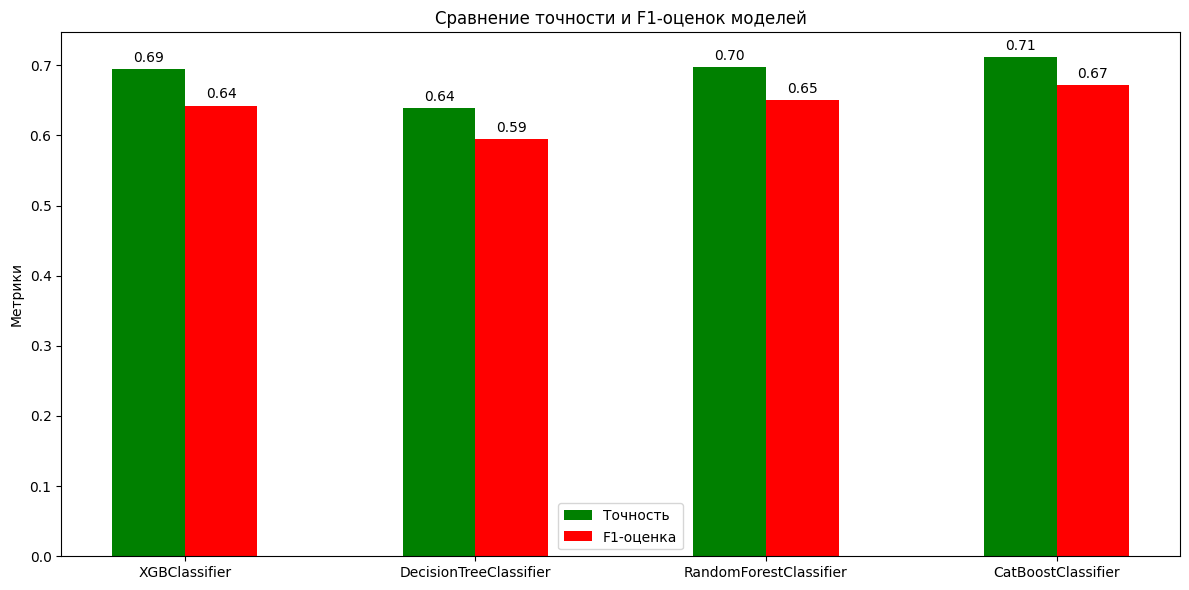

In [ ]:
# Списки для хранения метрик моделей: точности (accuracy) и F1-оценки
models_names = list(best_models.keys())  # Получаем названия всех моделей из best_models
accuracies = []  # Список для сохранения значений accuracy
f1_scores = []   # Список для сохранения значений F1-score

# Цикл для вычисления метрик для каждой модели
for classifier_name, model_data in best_models.items():
    best_model = model_data['best_model']
    y_test_pred = best_model.predict(X_test)

    # Вычисляем метрики
    accuracy = accuracy_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    # Добавляем результаты в списки
    accuracies.append(accuracy)
    f1_scores.append(f1)


x = np.arange(len(models_names))  # Массив индексов для размещения столбцов
width = 0.25
# Создаём график размером 12x6
fig, ax = plt.subplots(figsize=(12, 6))

# Строим два набора столбцов:
bars1 = ax.bar(x - width/2, accuracies, width, label='Точность', color='green')
bars2 = ax.bar(x + width/2, f1_scores, width, label='F1-оценка', color='red')

# Настраиваем ось Y и заголовок графика
ax.set_ylabel('Метрики')
ax.set_title('Сравнение точности и F1-оценок моделей')
ax.set_xticks(x)
ax.set_xticklabels(models_names)
ax.legend()


# Функция для добавления численных значений на верхушку каждого столбца
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

# Добавляем значения на обе группы столбцов
add_labels(bars1)
add_labels(bars2)

plt.tight_layout()

# Отображаем график
plt.show()

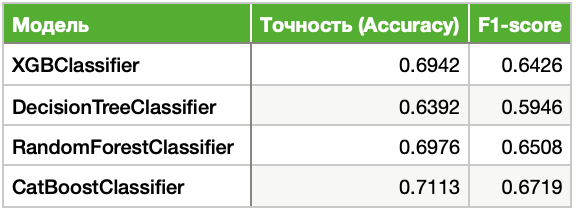


1. CatBoostClassifier показывает наилучшие результаты, имеет наивысшую точность (Accuracy) и F1-score, что говорит о том, что модель лучше всего справляется с задачей.

2. RandomForestClassifier демонстрирует стабильное качество
Следом за CatBoost следует Random Forest с немного худшими, но всё ещё хорошими значениями метрик.

3. XGBoostRegressor имеет средние результаты, показатели Accuracy и F1-score у XGBoost близки к Random Forest. Разница между ними незначительна, но она всё же есть в пользу CatBoost и Random Forest.

4. DecisionTreeClassifier хуже остальных моделей, имеет самые низкие значения Accuracy и F1-score, что указывает на низкую способность обобщать данные.

Вывод:

- CatBoostClassifier — лучшая модель для текущей задачи классификации.
Оптимальные гиперпараметры для CatBoostClassifier обеспечивают хороший баланс между скоростью обучения и качеством предсказаний, что делает модель надежной и эффективной.

- RandomForestClassifier может быть альтернативой, которая также эффективно решает задачу.

- XGBoostRegressor — подходящая модель, но не лидирует по качеству.

- DecisionTreeClassifier не рекомендуется использовать как основную модель в данной задаче.



In [ ]:
def save_model(model, model_name):
    """ Сохраняет модель в файл с расширением .pkl """
    filename = f"{model_name}_IC50.pkl"
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
        print(f"Модель '{filename}' сохранена.")


def load_model(model_name):
    """ Загружает ранее сохранённую модель из файла """
    filename = f"{model_name}_IC50.pkl"
    try:
        with open(filename, 'rb') as file:
            model = pickle.load(file)
        print(f"Модель '{filename}' загружена.")
        return model
    except FileNotFoundError:
        print(f"Ошибка: файл '{filename}' не найден.")  # Сообщаем об ошибке, если файл отсутствует
        return None  # Возвращаем None при ошибке


# Сохраняем каждую из оптимальных моделей в отдельный файл
for classifier_name, model_data in best_models.items():
    save_model(model_data['best_model'], classifier_name)


# Загружаем все модели обратно из файлов
loaded_models = {
    'XGBClassifier': load_model('XGBClassifier'),
    'DecisionTreeClassifier': load_model('DecisionTreeClassifier'),
    'RandomForestClassifier': load_model('RandomForestClassifier'),
    'CatBoostClassifier': load_model('CatBoostClassifier')
}

Модель 'XGBClassifier_IC50.pkl' сохранена.
Модель 'DecisionTreeClassifier_IC50.pkl' сохранена.
Модель 'RandomForestClassifier_IC50.pkl' сохранена.
Модель 'CatBoostClassifier_IC50.pkl' сохранена.
Модель 'XGBClassifier_IC50.pkl' загружена.
Модель 'DecisionTreeClassifier_IC50.pkl' загружена.
Модель 'RandomForestClassifier_IC50.pkl' загружена.
Модель 'CatBoostClassifier_IC50.pkl' загружена.


In [ ]:
# Проверка загруженной модели
for name, model in loaded_models.items():
    if model is not None:
        y_test_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_test_pred)
        f1 = f1_score(y_test, y_test_pred)
        print(f"{name} - Тестовые метрики после загрузки:")
        print(f"  Accuracy: {acc:.4f}")
        print(f"  F1-score: {f1:.4f}\n")
    else:
        print(f"Модель '{name}_IC50.pkl' НЕ загружена — файл не найден.\n")

XGBClassifier - Тестовые метрики после загрузки:
  Accuracy: 0.6942
  F1-score: 0.6426

DecisionTreeClassifier - Тестовые метрики после загрузки:
  Accuracy: 0.6392
  F1-score: 0.5946

RandomForestClassifier - Тестовые метрики после загрузки:
  Accuracy: 0.6976
  F1-score: 0.6508

CatBoostClassifier - Тестовые метрики после загрузки:
  Accuracy: 0.7113
  F1-score: 0.6719



In [ ]:
import os
# Проверяем все файлы в текущей директории
os.listdir()

['.config',
 'CatBoostClassifier_IC50.pkl',
 'XGBClassifier_IC50.pkl',
 'DecisionTreeClassifier_IC50.pkl',
 'drive',
 'catboost_info',
 'RandomForestClassifier_IC50.pkl',
 'sample_data']